### 0. Ścieżki

In [9]:
### 0. Ścieżki do plików CSV

"""
Ustawia wspólny katalog na wszystkie pliki CSV z tego notatnika.

OUTPUT_CSV_DIR – katalog na wyniki pośrednie (kandydaci na dc:subject itd.).
"""

import os

OUTPUT_CSV_DIR = "outputs/csv"
os.makedirs(OUTPUT_CSV_DIR, exist_ok=True)

### 1. Importy i konfiguracja środowiska

In [10]:
"""
03_scene_clip.ipynb – klasyfikacja typu sceny przy użyciu CLIP (zero-shot).
"""
from pathlib import Path
from datetime import datetime, timezone
from contextlib import nullcontext
import json

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# importy CLIP z naszego modułu src/
from src.clip_utils import (
    get_device,
    load_clip_model,
    run_clip_scene_batch,
)

### 2. Ustawienia urządzenia i precyzji FP16 dla CLIP

In [11]:
"""
Ustawienia urządzenia i precyzji FP16 dla CLIP.
"""

device = get_device()
IMG_DTYPE = (
    "fp16" if device.type in ("cuda", "mps") else "fp32"
)
TEXT_DTYPE = IMG_DTYPE

print("Device:", device, "| IMG_DTYPE:", IMG_DTYPE)

Device: mps | IMG_DTYPE: fp16


### 3. Ścieżki wejścia/wyjścia i ładowanie modelu CLIP

In [12]:
"""
Ścieżki wejścia/wyjścia dla klasyfikacji scen oraz ładowanie modelu CLIP.
"""

PROJECT_ROOT = Path(".").resolve()

# wspólny katalog wejściowy na obrazy
DIR_INPUTS = PROJECT_ROOT / "inputs"

# katalog na inne wyniki (np. wykresy itp.)
DIR_OUT = PROJECT_ROOT / "outputs"
DIR_OUT.mkdir(parents=True, exist_ok=True)

# wspólny katalog na wszystkie CSV
OUTPUT_CSV_DIR = PROJECT_ROOT / "outputs" / "csv"
OUTPUT_CSV_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = OUTPUT_CSV_DIR / "clip_scene_subjects.csv"

LOGS_DIR = PROJECT_ROOT / "logs"
LOGS_DIR.mkdir(parents=True, exist_ok=True)
RUNLOG_PATH = LOGS_DIR / "runlog.jsonl"

print("Wejście (obrazy):", DIR_INPUTS)
print("Wyjście (CSV):  ", CSV_PATH)

# ładowanie modelu CLIP
model, preprocess, tokenizer = load_clip_model(
    model_name="ViT-B-32",
    pretrained="openai",
    device=device,
)

Wejście (obrazy): /Users/olga/MetaLogic/inputs
Wyjście (CSV):   /Users/olga/MetaLogic/outputs/csv/clip_scene_subjects.csv


/Users/olga/MetaLogic/.venv/lib/python3.13/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


### 4. Definicja etykiet scen i promptów tekstowych

In [13]:
"""
Definicja etykiet scen i promptów tekstowych.

SCENE_LABELS_PL – etykiety, które trafią potem do kolumny 'scene_label'
PROMPTS         – teksty, które podajemy CLIP-owi (EN).
"""

### 0.X Słownik scen CLIP z pliku CSV

"""
Wczytuje słownik scen dla CLIP z pliku:
    data/dictionary_scenes.csv

Oczekiwany format CSV:
    scene_pl,scene_en

Na tej podstawie budujemy listę LABEL_TO_PROMPT
używaną dalej w notatniku 03_clip_scene_classification.
"""

from pathlib import Path
import pandas as pd

# jeśli z jakiegoś powodu PROJECT_ROOT jeszcze nie istnieje, ustaw lokalnie
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path(".").resolve()

P_SCENES_DICT = PROJECT_ROOT / "data" / "dictionary_scenes.csv"

df_scenes = pd.read_csv(P_SCENES_DICT)

# kontrolnie możesz sprawdzić, czy kolumny są poprawne
assert {"scene_pl", "scene_en"}.issubset(df_scenes.columns), df_scenes.columns

LABEL_TO_PROMPT = list(
    df_scenes[["scene_pl", "scene_en"]]
    .itertuples(index=False, name=None)
)

print(f"[03] Załadowano {len(LABEL_TO_PROMPT)} scen z dictionary_scenes.csv")

# etykiety PL i prompty EN wyciągamy z listy:
SCENE_LABELS_PL = [pl for (pl, en) in LABEL_TO_PROMPT]
PROMPTS         = [en for (pl, en) in LABEL_TO_PROMPT]

# słowniki:
# EN prompt -> PL label
PROMPT_TO_LABEL_PL = {en.strip(): pl.strip() for (pl, en) in LABEL_TO_PROMPT}
# PL label -> EN prompt (do eksportu)
LABEL_PL_TO_EN     = {pl.strip(): en.strip() for (pl, en) in LABEL_TO_PROMPT}

print("Liczba etykiet scen:", len(SCENE_LABELS_PL))

[03] Załadowano 56 scen z dictionary_scenes.csv
Liczba etykiet scen: 56


### 5. Klasyfikacja scen: score_CLIP dla wszystkich obrazów

In [14]:
"""
Wczytuje wszystkie obrazy z katalogu, przepuszcza każdy przez CLIP Zero-Shot,
wyznacza najlepszą scenę dla każdego zdjęcia, mierzy czas, pokazuje progress bar
i zapisuje wyniki do CSV.

Wyjście:
    outputs/csv/clip_scene_results.csv z kolumnami:
        file_name, scene_label, scene_score
"""

from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd

# dozwolone rozszerzenia obrazów
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"}

image_paths = [
    p for p in sorted(DIR_INPUTS.glob("*"))
    if p.is_file() and p.suffix.lower() in IMAGE_EXTS
]

print("Liczba znalezionych obrazów:", len(image_paths))

df_scenes = run_clip_scene_batch(
    model=model,
    preprocess=preprocess,
    tokenizer=tokenizer,
    image_paths=tqdm(image_paths, desc="CLIP scene classification"),
    scene_labels=PROMPTS,   # prompty EN
    device=device,
)

# zamiana file_path → file_name i uporządkowanie kolumn
df_scenes["file_name"] = df_scenes["file_path"].astype(str).map(lambda p: Path(p).name)
df_scenes = df_scenes[["file_name", "scene_label", "scene_score"]]

OUT_SCENES_CSV = OUTPUT_CSV_DIR / "clip_scene_results.csv"
OUT_SCENES_CSV.parent.mkdir(parents=True, exist_ok=True)
df_scenes.to_csv(OUT_SCENES_CSV, index=False)

print("[03] Zapisano wyniki scen do:", OUT_SCENES_CSV)
df_scenes.head()

Liczba znalezionych obrazów: 134


CLIP scene classification:   0%|          | 0/134 [00:00<?, ?it/s]

/Users/olga/MetaLogic/src/clip_utils.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=dev.type != "cpu"):
/Users/olga/MetaLogic/.venv/lib/python3.13/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/olga/MetaLogic/src/clip_utils.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=dev.type != "cpu"):


[03] Zapisano wyniki scen do: /Users/olga/MetaLogic/outputs/csv/clip_scene_results.csv


file_name                             scene_label  scene_score
0    0000.jpg                            car exterior     0.018574
1  000202.jpg  graffiti or political slogans on walls     0.018881
2  000238.jpg                            car exterior     0.019300
3    0003.jpg                            car exterior     0.018994
4  000345.jpg                            car exterior     0.018869

### 6. Przekształcenie etykiet EN→PL i zapis wyników (CSV + runlog)

In [15]:
"""
Zamiana etykiet scen EN→PL oraz zapis wyników do CSV i runlog.jsonl.

CSV wyjściowy:
- kolumny: file_name, subject_en, subject_pl, scene_score
- bez timestampu, bez file_path.
"""

from datetime import datetime, timezone
import json

df_scenes = df_scenes.copy()

# 1) normalizacja nazw plików i etykiet
df_scenes["file_name"] = df_scenes["file_name"].astype(str)
df_scenes["scene_label_norm"] = df_scenes["scene_label"].astype(str).str.strip()

# 2) subject_en = etykieta EN z CLIP-a
df_scenes["subject_en"] = df_scenes["scene_label_norm"]

# 3) subject_pl = tłumaczenie EN→PL ze słownika PROMPT_TO_LABEL_PL
df_scenes["subject_pl"] = df_scenes["scene_label_norm"].map(PROMPT_TO_LABEL_PL).fillna("")

# 4) DataFrame do eksportu – tylko kolumny potrzebne dalej
df_out = df_scenes[["file_name", "subject_en", "subject_pl", "scene_score"]].copy()

# 5) zapis CSV
df_out.to_csv(CSV_PATH, index=False)
print("Zapisano CSV:", CSV_PATH)
print(df_out.head())

# 6) wpis do runlog.jsonl
timestamp = datetime.now(timezone.utc).isoformat()

runlog_entry = {
    "timestamp": timestamp,
    "step": "scene_clip",
    "n_images": int(len(df_out)),
    "csv_path": str(CSV_PATH),
    "model_name": "ViT-B/32",
    "pretrained": "openai",
    "device": str(device),
    "dtype": str(IMG_DTYPE),
}
with RUNLOG_PATH.open("a", encoding="utf-8") as f:
    f.write(json.dumps(runlog_entry, ensure_ascii=False) + "\n")
print("Dopisano wpis do:", RUNLOG_PATH)

Zapisano CSV: /Users/olga/MetaLogic/outputs/csv/clip_scene_subjects.csv
    file_name                              subject_en  \
0    0000.jpg                            car exterior   
1  000202.jpg  graffiti or political slogans on walls   
2  000238.jpg                            car exterior   
3    0003.jpg                            car exterior   
4  000345.jpg                            car exterior   

                   subject_pl  scene_score  
0                        auto     0.018574  
1  napisy lub hasła na murach     0.018881  
2                        auto     0.019300  
3                        auto     0.018994  
4                        auto     0.018869  
Dopisano wpis do: /Users/olga/MetaLogic/logs/runlog.jsonl


### 7. Podgląd miniatur pogrupowanych wg etykiet sceny (mini-galeria)

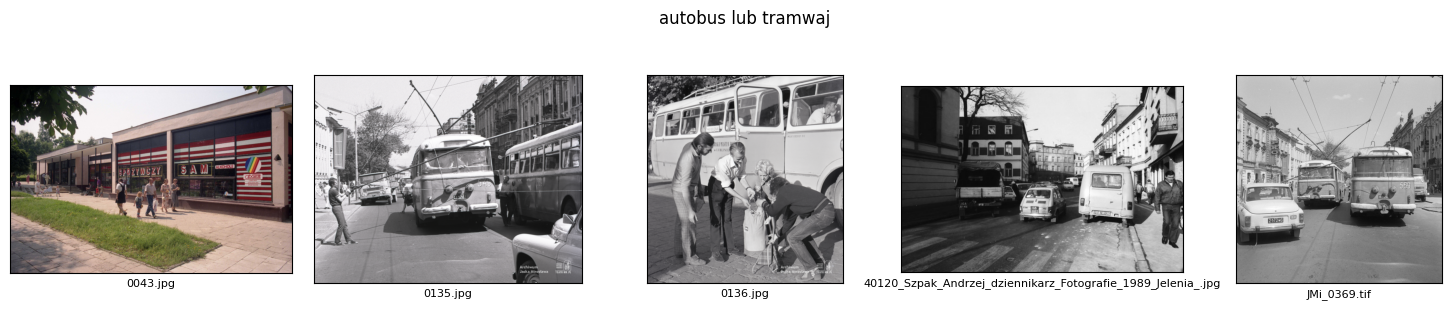

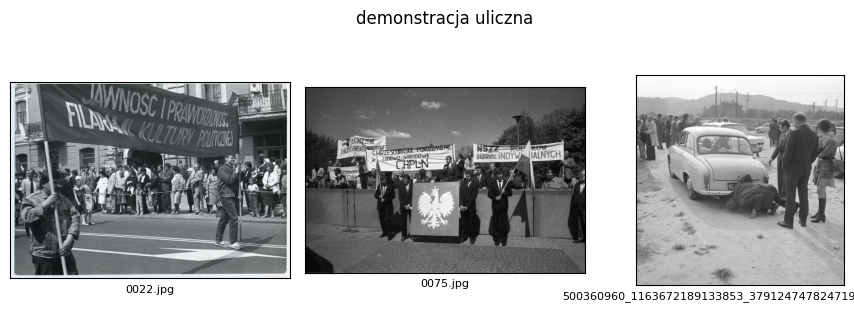

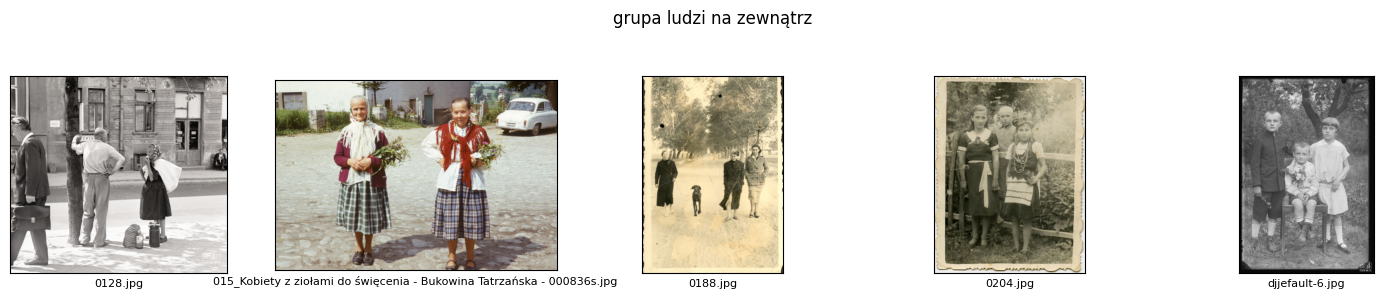

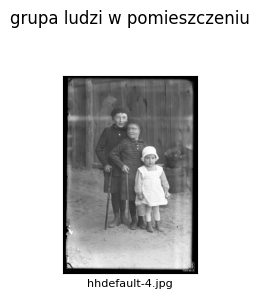

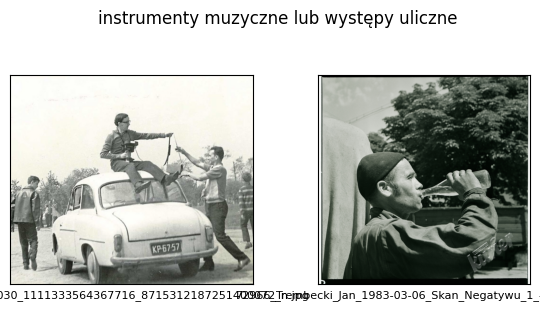

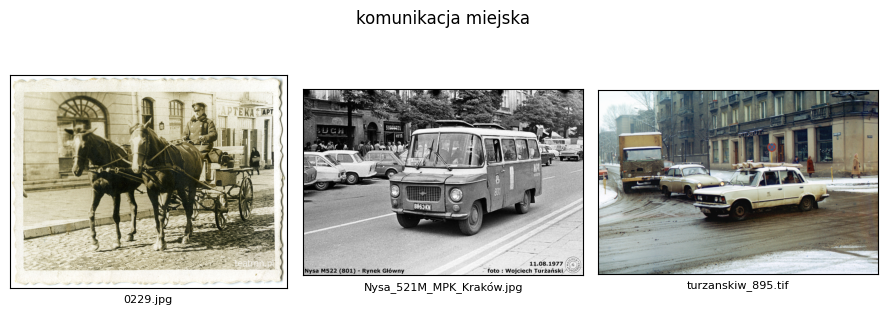

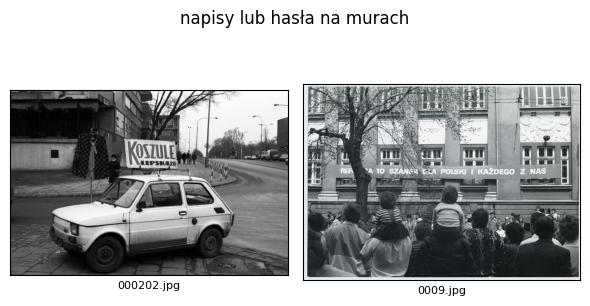

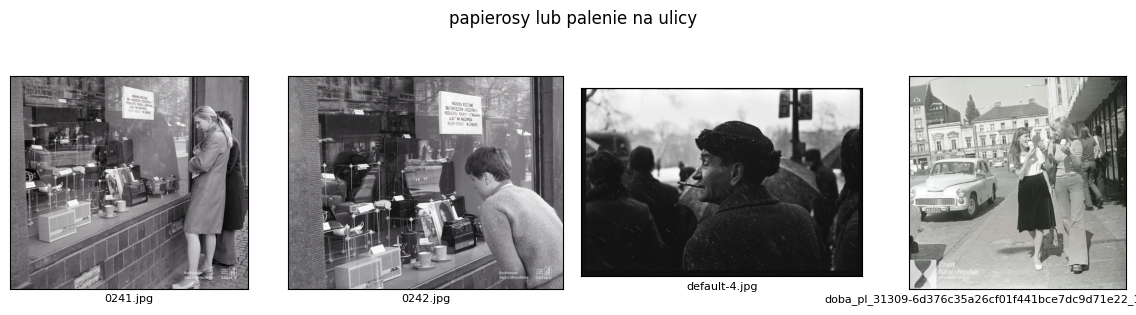

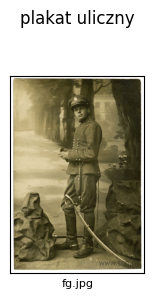

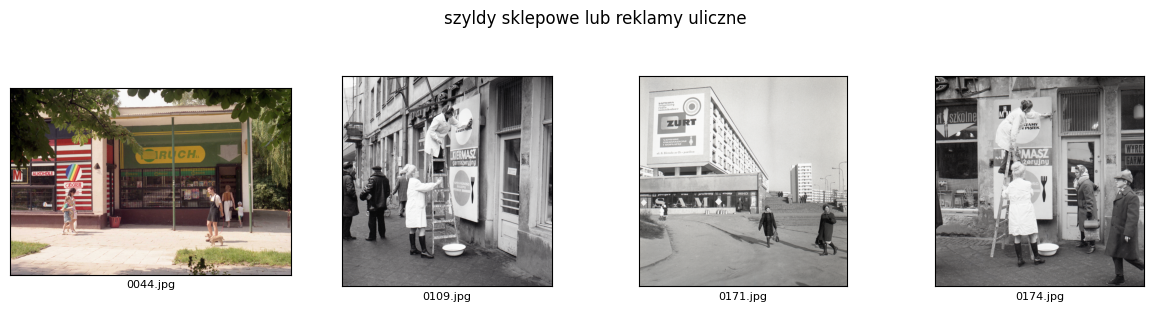

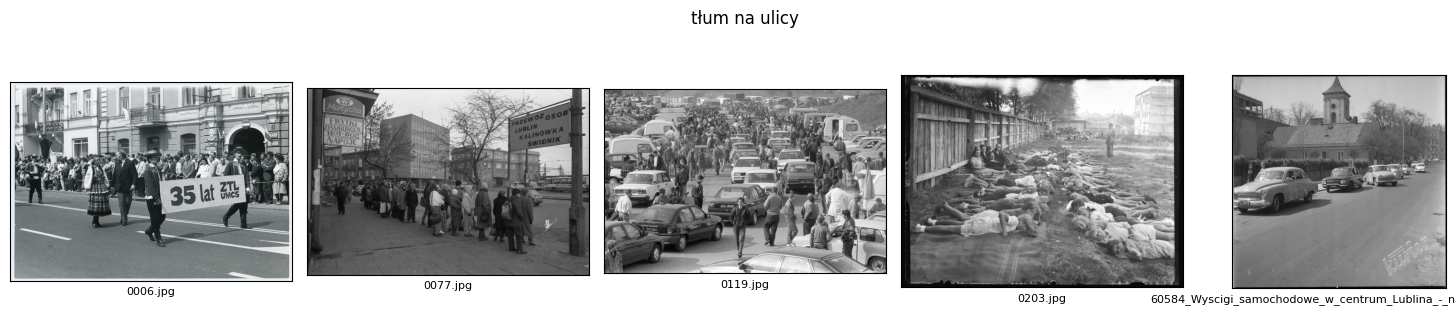

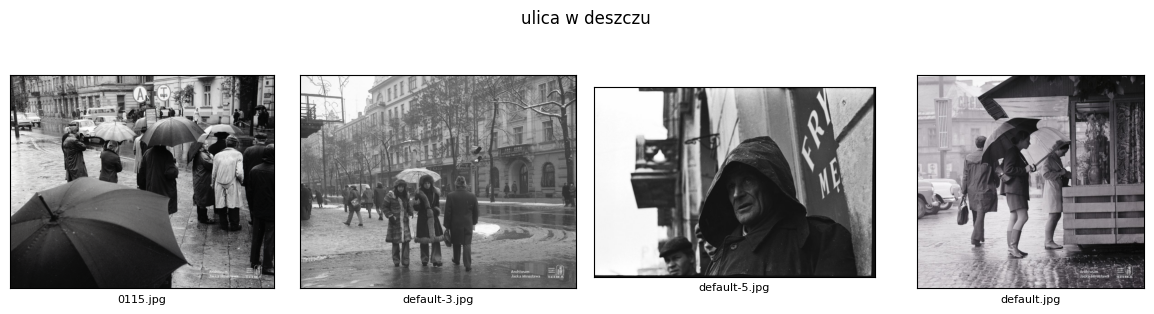

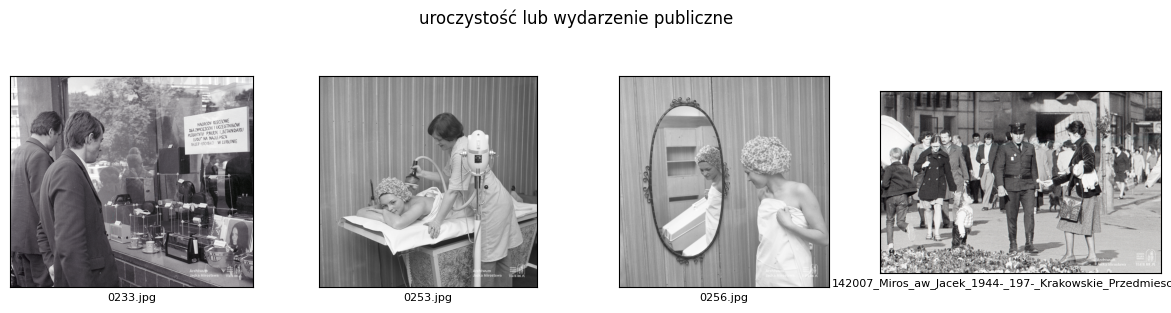

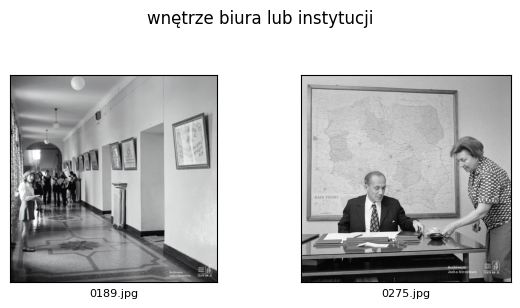

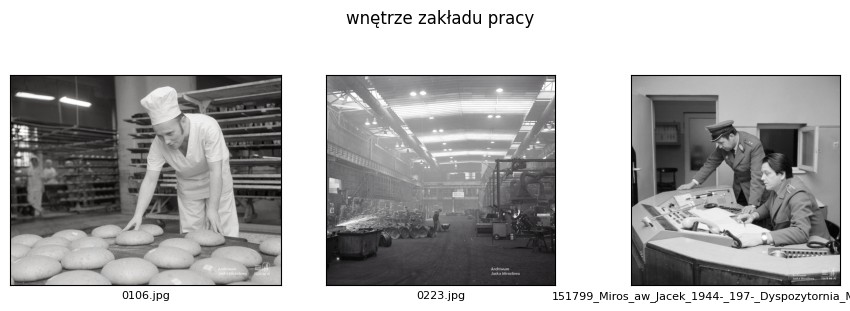

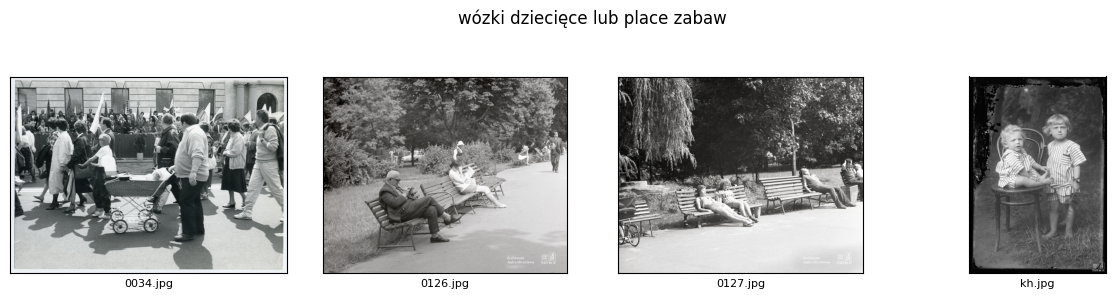

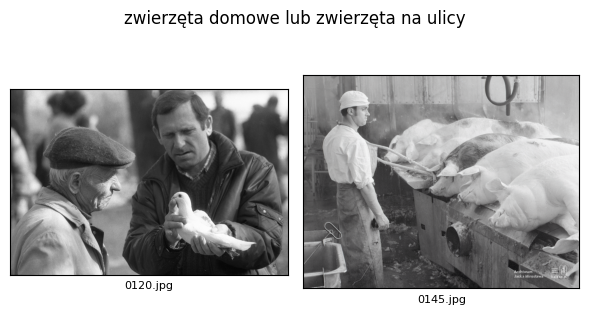

In [16]:
"""
Podgląd miniatur pogrupowanych wg przypisanej etykiety sceny (PL, jeśli jest).
"""

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def show_thumbnails_all_labels(
    df_scenes: pd.DataFrame,
    images_dir: Path,
    n_per_label: int = 5,
) -> None:
    """
    df_scenes  – DataFrame z kolumnami:
                 'file_name' (str), 'scene_label' (EN), opcjonalnie 'subject_pl' (PL)
    images_dir – katalog, w którym leżą obrazy (np. DIR_INPUTS)
    """
    if df_scenes.empty:
        print("df_scenes jest pusty – brak danych do podglądu.")
        return

    # jeśli mamy subject_pl, używamy go jako etykiety sceny
    label_col = "subject_pl" if "subject_pl" in df_scenes.columns else "scene_label"

    labels = sorted(df_scenes[label_col].dropna().unique())

    for label in labels:
        subset = (
            df_scenes[df_scenes[label_col] == label]
            .drop_duplicates(subset=["file_name"])
            .head(n_per_label)
        )

        if subset.empty:
            continue

        n_cols = len(subset)
        fig, axes = plt.subplots(1, n_cols, figsize=(3 * n_cols, 3))
        if n_cols == 1:
            axes = [axes]

        fig.suptitle(str(label), fontsize=12)

        for ax, (_, rec) in zip(axes, subset.iterrows()):
            ax.set_xticks([])
            ax.set_yticks([])

            img_path = images_dir / rec["file_name"]
            try:
                img = Image.open(img_path).convert("RGB")
            except Exception:
                ax.axis("off")
                continue

            ax.imshow(img)
            ax.set_xlabel(rec["file_name"], fontsize=8)

        plt.tight_layout(rect=(0, 0, 1, 0.92))
        plt.show()


show_thumbnails_all_labels(df_scenes, DIR_INPUTS, n_per_label=5)